In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Familiar stack packages
import numpy as np
import astropy.table as astTable
from lsst.daf.butler import Butler
import lsst.geom as geom
import xlens
import fitsio
import glob

import matplotlib.pyplot as plt
import lsst.afw.image as afwImage
import lsst.afw.table as afwTable
import anacal
import galsim

In [2]:
from lsst.skymap.ringsSkyMap import RingsSkyMapConfig, RingsSkyMap
cfg = RingsSkyMapConfig()

# make the patch the same size as the tract -> exactly 1 patch per tract
cfg.patchInnerDimensions = [501, 501]
cfg.tractOverlap = 0.0

# optional: keep borders simple
cfg.patchBorder = 0        # pixels
cfg.numRings = 7000
cfg.pixelScale = 0.2
cfg.projection = "TAN"
# build it
skymap0 = RingsSkyMap(config=cfg)
# Set up the configuration
tract_info = skymap0[0]
rng = np.random.RandomState(0)
catalog = xlens.simulator.galaxies.CatSim2017Catalog(
    rng=rng,
    tract_info=tract_info,
    layout_name="random",
)


In [22]:
wcs = skymap0[50000000].getWcs()

In [26]:
wcs.getPixelOrigin().x
wcs.getPixelOrigin().y

250.0

In [29]:
a= wcs.getSkyOrigin()

In [32]:
a.getRa().asDegrees()

266.8693552713941

In [27]:
help(wcs.pixelToSkyArray)

Help on method pixelToSkyArray in module lsst.afw.geom.skyWcs:

pixelToSkyArray(x, y, degrees=False) method of lsst.afw.geom.SkyWcs instance
    Convert numpy array pixels (x, y) to numpy array sky (ra, dec)
    positions.
    
    Parameters
    ----------
    x : `np.ndarray`
        Array of x values.
    y : `np.ndarray`
        Array of y values.
    degrees : `bool`, optional
        Return ra, dec arrays in degrees if True.
    
    Returns
    -------
    ra : `np.ndarray`
        Array of Right Ascension.  Units are radians unless
        degrees=True.
    dec : `np.ndarray`
        Array of Declination.  Units are radians unless
        degrees=True.



In [3]:
from xlens.simulator.sim import MultibandSimConfig, MultibandSimTask
cfg = MultibandSimConfig()
simtask = MultibandSimTask(config=cfg)
out = simtask.run(        
    tract_info=tract_info,
    patch_id=0,
    band="i",
    seed=0,
    catalog=catalog.data,
)

In [ ]:
out.outputTruthCatalog

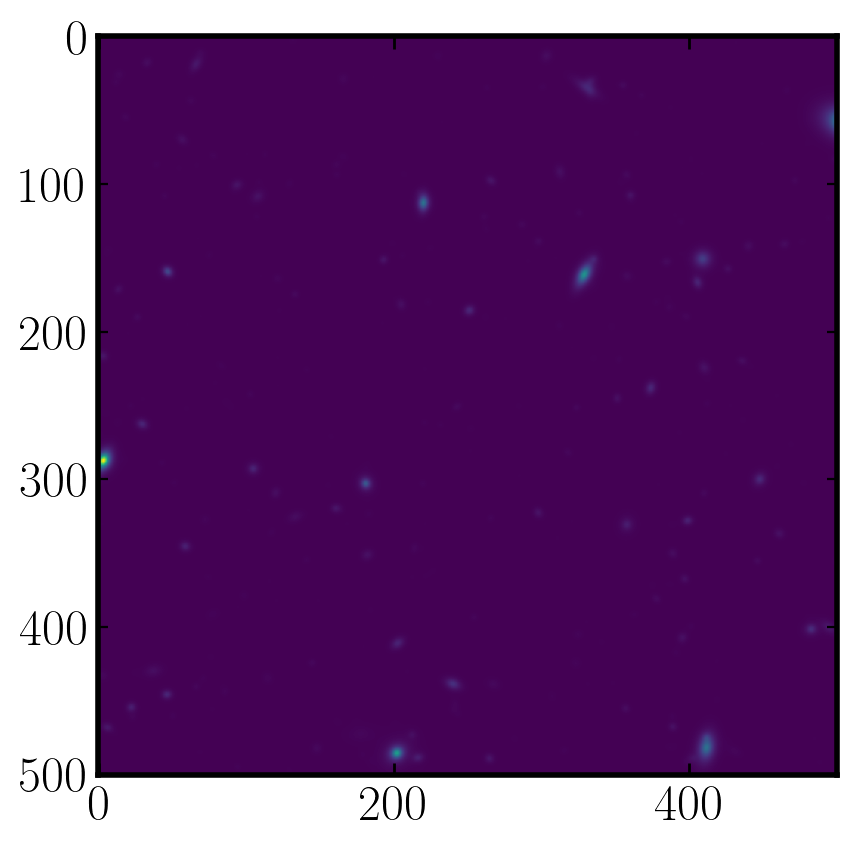

In [9]:
plt.imshow(out.outputExposure.image.array)

In [107]:
obs_repo = '/lustre/work/xiangchong.li/work/hsc_s23b_sim'
obs_collection = 'version1/image'

obs_butler = Butler(obs_repo, collections=obs_collection)
obs_registry = obs_butler.registry
skymap = obs_butler.get('skyMap', skymap="hsc")

In [108]:
rootdir = os.environ["s23b"]
full = fitsio.read(
    f"{rootdir}/tracts_fdfc_v1_final.fits"
)
full = full[full["tract"] == 16012]
entry = full[-1]
tract_id = entry["tract"]
patch_db = entry["patch"]
patch_x = patch_db // 100
patch_y = patch_db % 100
patch_id = patch_x + patch_y * 9

In [109]:
full["patch"]

array([500, 600, 601, 700, 701, 702, 703, 800, 801, 802, 803, 804, 805],
      dtype='>i4')

In [112]:
import galsim

In [ ]:
type(skymap[tract_id])

In [212]:
skyWcs = skymap[tract_id].getWcs()
sky_center = skymap[tract_id].getCtrCoord()
pix_center = skyWcs.skyToPixel(sky_center)
x0 = pix_center.getX()
y0 = pix_center.getY()
lin = skyWcs.linearizePixelToSky(sky_center, geom.radians)
J = np.array(lin.getLinear().getMatrix(), dtype=np.float64)  # 2x2, rad/pix
RAD2ASEC = 206264.80624709636
# Convert to arcsec/pixel for GalSim
J_arcsec = J * RAD2ASEC
aff = galsim.AffineTransform(
    dudx=J_arcsec[0, 0], dudy=J_arcsec[0, 1],
    dvdx=J_arcsec[1, 0], dvdy=J_arcsec[1, 1],
    origin=galsim.PositionD(x0, y0),
)
world_origin = galsim.CelestialCoord(
    sky_center.getRa().asRadians() * galsim.radians,
    sky_center.getDec().asRadians() * galsim.radians,
)

wcs_galsim = galsim.TanWCS(
    affine=aff, world_origin=world_origin, units=galsim.arcsec
)

In [213]:
scale = 0.168
mat = np.array(
    [[scale, 0.0],
     [0.0, scale]],
)
image_origin = galsim.PositionD(x=0, y=0)
wcs_galsim =  galsim.TanWCS(
    affine=galsim.AffineTransform(
        mat[0, 0], mat[0, 1], mat[1, 0], mat[1, 1],
        origin=image_origin,
    ),
    world_origin=world_origin,
    units=galsim.arcsec,
)

crpix = wcs_galsim.crpix
stack_crpix = geom.Point2D(crpix[0], crpix[1])
cd_matrix = wcs_galsim.jacobian(
    galsim.PositionD(crpix[0], crpix[1])
).getMatrix() / 3600.0

In [198]:
wcs_galsim.jacobian(
    galsim.PositionD(crpix[0], crpix[1])
).getMatrix()

array([[0.168, 0.   ],
       [0.   , 0.168]])

In [214]:
cd_matrix

array([[4.66666667e-05, 0.00000000e+00],
       [0.00000000e+00, 4.66666667e-05]])

In [151]:
wcs_galsim.toWorld(galsim.PositionD(x=100, y=0))

coord.CelestialCoord(coord.Angle(-8.14486982462948e-05, coord.radians), coord.Angle(0.0, coord.radians))

In [215]:
wcs_galsim.cd

array([[-4.66666667e-05, -0.00000000e+00],
       [ 0.00000000e+00,  4.66666667e-05]])

In [178]:
wcs_local = wcs_galsim.local(
    galsim.PositionD(crpix[0], crpix[1])
)

In [179]:
wcs_local.getMatrix()

array([[0.168, 0.   ],
       [0.   , 0.168]])

In [142]:
cd_matrix

array([[4.66666667e-05, 0.00000000e+00],
       [0.00000000e+00, 4.66666667e-05]])

In [143]:
wcs_galsim.cd

array([[-4.66666667e-05, -0.00000000e+00],
       [ 0.00000000e+00,  4.66666667e-05]])

In [115]:
wcs_galsim.cd

array([[ 4.66666667e-05,  3.66777046e-14],
       [-3.65477538e-11,  4.66666667e-05]])

In [117]:
J

array([[-8.14486984e-07, -6.40146707e-16],
       [-6.37878639e-13,  8.14486985e-07]])

In [130]:
world_origin = galsim.CelestialCoord(0*galsim.degrees, 0*galsim.degrees)  # RA=180°, Dec=0°

In [132]:
dep = world_origin.deproject(u=0.1 * galsim.degrees, v=0.1 * galsim.degrees)
print(dep.ra.deg)
print(dep.dec.deg)

-0.09999989846104566
0.09999974615314768


In [128]:
help(world_origin.deproject)

Help on method deproject in module coord.celestial:

deproject(u, v, projection=None) method of coord.celestial.CelestialCoord instance
    Do the reverse process from the project() function.
    
    i.e. This takes in a position (u,v) and returns the corresponding celestial
    coordinate, using the current coordinate as the center point of the tangent plane
    projection.
    
    :param u:           The u position on the tangent plane to deproject (must be an Angle
                        instance)
    :param v:           The v position on the tangent plane to deproject (must be an Angle
                        instance)
    :param projection:  The name of the projection to be used. [default: gnomonic, see ``project``
                        docstring for other options]
    
    :returns: the corresponding CelestialCoord for that position.



In [126]:
b.deg

179.90000010153895

In [125]:
b=a.ra

In [116]:
wcs_galsim.

<bound method BaseWCS.affine of galsim.GSFitsWCS(_data = ['TAN', array([17999.0, 17999.0]), array([[4.666666666978223e-05, 3.6677704606877464e-14], [-3.654775384470939e-11, 4.666666668157272e-05]]), coord.CelestialCoord(coord.Angle(4.366281315158695, coord.radians), coord.Angle(0.7659254816603216, coord.radians)), None, None, None])>

In [104]:
wcs_galsim.crpix

array([17999., 17999.])

In [ ]:
galsim

In [38]:
lin.getLinear().getMatrix()

array([[-8.14486984e-07, -6.40146707e-16],
       [-6.37878639e-13,  8.14486985e-07]])

In [62]:
J_arcsec

array([[-1.68000000e-01, -1.32039737e-10],
       [-1.31571914e-07,  1.68000000e-01]])

In [40]:
lin = skyWcs.linearizePixelToSky(sky_center, geom.degrees)

In [41]:
lin

AffineTransform(
[[-4.66666667e-05 -3.66777046e-14  2.51009445e+02]
 [-3.65477538e-11  4.66666667e-05  4.30443448e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
)

In [54]:
wcs_galsim.jacobian(galsim.PositionD(0, 0))

galsim.JacobianWCS(-0.16793013256288927, 0.0023348682526315276, 0.002298654138136848, 0.16792963299522642)

In [61]:
skyWcs.

array([[-9.62569096,  0.        ],
       [ 0.        ,  9.62569096]])

In [69]:
lin = skyWcs.linearizePixelToSky(geom.Point2D(bbox.getCorners()[0]), geom.radians)
J = np.array(lin.getLinear().getMatrix(), dtype=np.float64)  # 2x2, rad/pix
RAD2ASEC = 206264.80624709636
# Convert to arcsec/pixel for GalSim
J_arcsec = J * RAD2ASEC

In [78]:
lin = skyWcs.linearizePixelToSky(geom.Point2D(0, 0), geom.radians)
J = np.array(lin.getLinear().getMatrix(), dtype=np.float64)  # 2x2, rad/pix
RAD2ASEC = 206264.80624709636
# Convert to arcsec/pixel for GalSim
J_arcsec = J * RAD2ASEC

In [11]:
tract_info = skymap[16012]
wcs = tract_info.getWcs()
bbox = tract_info.getBBox()
layout = xlens.simulator.layout.Layout(
    layout_name="random",
    wcs=wcs,
    boundary_box=bbox,
    sep_arcsec=None,
    pad_arcsec=10.0,
)

rng = np.random.RandomState(0)
catalog = xlens.simulator.galaxies.CatSim2017Catalog(
    rng=rng,
    layout=layout,
)
arr = catalog.to_array()

In [29]:
patch_info = tract_info[1]

In [30]:
bbox = patch_info.getOuterBBox()

In [31]:
bbox.beginX

3900

In [32]:
bbox.beginY

0

In [33]:
bbox.endX

8100

In [34]:
bbox.endY

4100

In [37]:
a = wcs.pixelToSky(x=3900, y=0)

In [42]:
a.getRa().asDegrees()
a.getDec().asDegrees()

43.0408772386878

In [43]:
b=a.getDec()

In [ ]:
b.

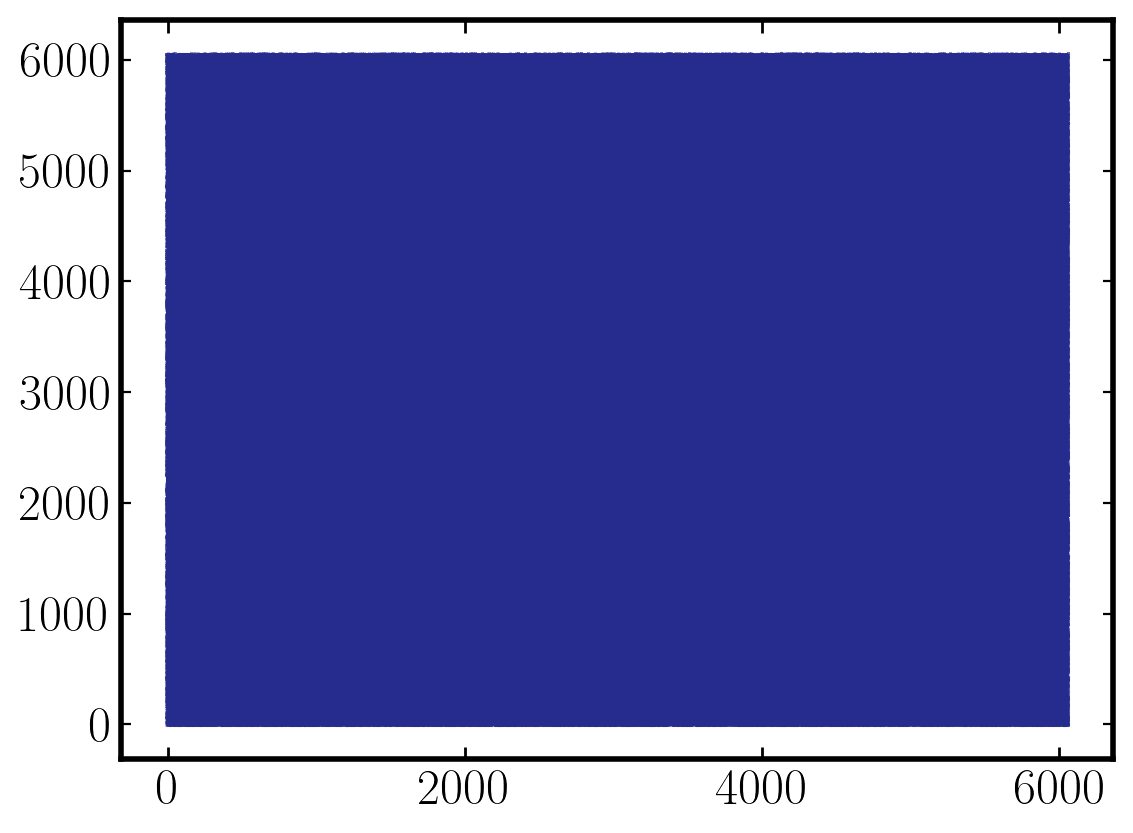

In [13]:
plt.scatter(arr["dx"], arr["dy"], s=0.01)

In [16]:
type(bbox)

lsst.geom.Box2I

In [15]:
36000 * 0.168

6048.0

In [201]:
skyWcs = tract_info.getWcs()
sky_center = tract_info.getCtrCoord()
pix_center = skyWcs.skyToPixel(sky_center)
x0 = pix_center.getX()
y0 = pix_center.getY()
lin = skyWcs.linearizePixelToSky(sky_center, geom.radians)
J = np.array(lin.getLinear().getMatrix(), dtype=np.float64)
# Convert to arcsec/pixel for GalSim
J_arcsec = J * RAD2ASEC
aff = galsim.AffineTransform(
    dudx=-J_arcsec[0, 0], dudy=-J_arcsec[0, 1],
    dvdx=J_arcsec[1, 0], dvdy=J_arcsec[1, 1],
    origin=galsim.PositionD(x0, y0),
)
world_origin = galsim.CelestialCoord(
    sky_center.getRa().asRadians() * galsim.radians,
    sky_center.getDec().asRadians() * galsim.radians,
)

wcs_galsim = galsim.TanWCS(
    affine=aff, world_origin=world_origin, units=galsim.arcsec
)

In [202]:
wcs_galsim.cd

array([[-4.66666667e-05, -3.66777046e-14],
       [-3.65477538e-11,  4.66666667e-05]])

In [203]:
a = wcs_galsim.toWorld(galsim.PositionD(x=0, y=0))
print(a.ra.deg)
print(a.dec.deg)

251.3185362077354
43.03865716947222


In [216]:
b=skyWcs.pixelToSky(geom.Point2D(0, 0))
print(b.getRa().asDegrees())
print(b.getDec().asDegrees())

In [220]:
(43.0386565122027 - 43.03865716947222) * 3600

-0.0023661702869048895

In [205]:
fname = glob.glob(f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_meas/{tract_id}/{patch_id}/i/*.fits")[0]
catalog = fitsio.read(fname)

In [206]:
cat = catalog[10]
print(cat["base_LocalWcs_CDMatrix_1_1"], cat["base_LocalWcs_CDMatrix_1_2"], cat["base_LocalWcs_CDMatrix_2_1"], cat["base_LocalWcs_CDMatrix_2_2"])
print(cat["base_SdssCentroid_x"], cat["base_SdssCentroid_y"])

-8.142427126712125e-07 -1.1199203783420957e-08 -1.1216211007031902e-08 8.143249756192469e-07
35530.338170137315 19914.25926115947


In [207]:
lin = skyWcs.linearizePixelToSky(
    geom.Point2D(cat["base_SdssCentroid_x"], cat["base_SdssCentroid_y"]),
    geom.radians,
)
J = np.array(lin.getLinear().getMatrix(), dtype=np.float64)


In [208]:
J

array([[-8.14242694e-07, -1.11992124e-08],
       [-1.12168502e-08,  8.14324975e-07]])

In [209]:
wcs_galsim.local(galsim.PositionD(cat["base_SdssCentroid_x"], cat["base_SdssCentroid_y"])).getMatrix()/ 3600.0 / 180 * np.pi

array([[ 8.14242704e-07,  1.11992043e-08],
       [-1.12168485e-08,  8.14324976e-07]])

In [211]:
wcs_galsim.local(galsim.PositionD(cat["base_SdssCentroid_x"], cat["base_SdssCentroid_y"])).getMatrix() / 0.168

array([[ 0.99970008,  0.01375001],
       [-0.01377167,  0.99980109]])